# Demo of SCOD on MNIST

In [26]:
%load_ext autoreload
%autoreload 2

import scod
import torch
import torch.nn as nn
import matplotlib
import numpy as np
from tqdm import trange

from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import Subset
from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
mnist = MNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
dataset = Subset(mnist, np.random.choice(len(mnist), 5000))

In [5]:
# DNN mapping 2d input to 1d distribution parameter
model = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(288, 10)
    )

# here, we interpret the output of the DNN as the mean of a Gaussian
dist_constructor = lambda theta: scod.distributions.Categorical(logits=theta)

mean_loss=0.178571: 100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


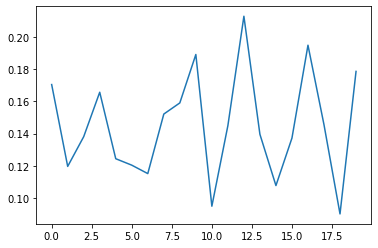

In [34]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

losses = []
t = trange(20)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        dist = dist_constructor(outputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss
        
        optimizer.step()
        
    epoch_loss /= len(train_dataloader)
    
    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [43]:
unc_model = scod.SCOD(model, dist_constructor, args={
    'num_eigs': 50,
    'num_samples': 304
})

In [44]:
unc_model.process_dataset(dataset)

computing basis
using T = 304


100%|██████████| 5000/5000 [00:56<00:00, 88.98it/s]


In [45]:
val_dataset =  MNIST(root="~/data/",train=False,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))
ood_dataset = FashionMNIST(root="~/data/",train=True,download=True,transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3801,))
]))

In [50]:
unc_model.calibrate(Subset(val_dataset, np.random.choice(len(val_dataset), 5000)),0.9)

100%|██████████| 500/500 [01:02<00:00,  8.04it/s]


In [39]:
## DEFINE VISUALIZATION FUNCTIONS
def plt_image(ax, inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = 0.1307
    std = 0.3081
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp[:,:,0], cmap='Greys')

def viz_dataset_sample(ax, dataset, idx=0, model=None, unc_model=None):
    input, target = dataset[idx]
    plt_image(ax, input)
    xlabel = 'Target: %d' % target
    if unc_model is not None:
        pred, unc = unc_model(input.unsqueeze(0))
        pred = np.argmax(pred[0].detach().cpu().numpy())
        unc = unc.item()
        xlabel += '\nPred: %d\nUnc: %0.3f' % (pred, unc)
    elif model is not None:
        pred = np.argmax( model(input.unsqueeze(0))[0].detach().cpu().numpy() )
        xlabel += '\nPred: %d' % pred
    ax.set_xlabel(xlabel)

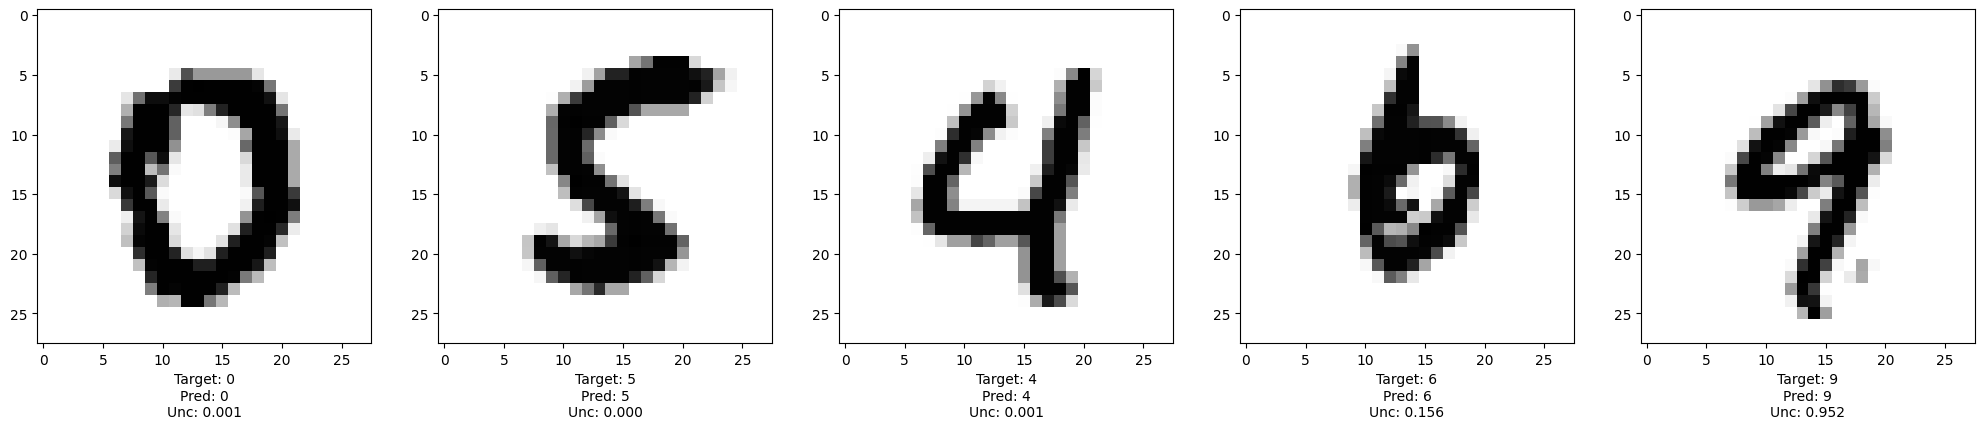

In [51]:
num_plots = 5
fig, axes = plt.subplots(1,num_plots, figsize=[5*num_plots, 5], dpi=100)
for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
    viz_dataset_sample( axes[j], dataset, idx, unc_model=unc_model )

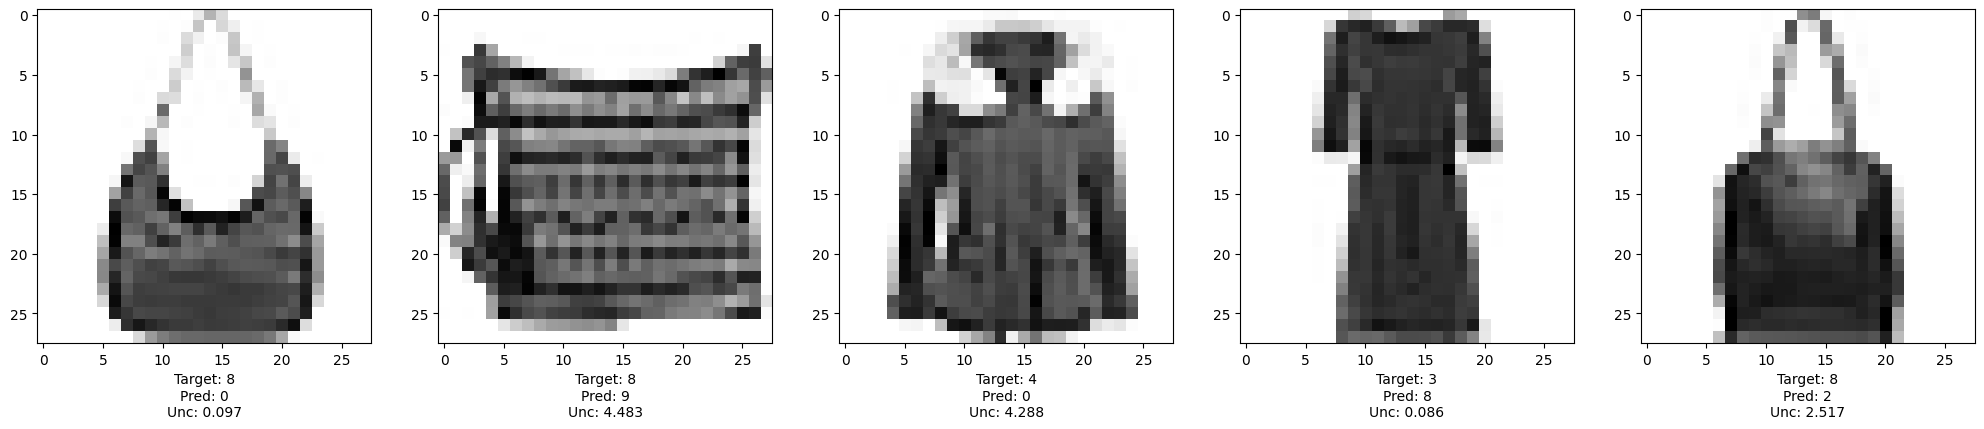

In [52]:
num_plots = 5
fig, axes = plt.subplots(1,num_plots, figsize=[5*num_plots, 5], dpi=100)
for j,idx in enumerate(np.random.choice(len(dataset), num_plots)):
    viz_dataset_sample( axes[j], ood_dataset, idx, unc_model=unc_model )